# Data Pruning for Ta Dataset

This notebook performs data pruning for the Ta dataset on all x,y and z directions of forces using the MEAGraph autoencoder model. The steps involved are:

1. **MEAGraph Autoencoder Training:**
  - Train the MEAGraph autoencoder on the Ta dataset.

2. **Inference:**
  - Specify the groups of data as the dataset for pruning (check available group names in `JSON` folder. e.g., using all groups).
  - Split the dataset into training and testing sets for subsequent ridge regression training (using a fixed random seed for reproducibility).  
  - Cluster the training dataset using the saved MEAGraph model (located in the `results` folder) to identify atomic clusters.

3. **Data Pruning:**
  - After MEAGraph inference, prune the training dataset by randomly removing a certain fraction (ranging from 0 to 0.9) of atoms from the clusters with large sizes. The cluster size ranges are determined by fitting the distribution of all cluster sizes to Gaussian Mixture Model.
  - Perform 20 random sampling iterations at each pruning fraction to ensure robustness.

4. **Ridge Regression Force Fitting:**
  - At each pruning fraction, train a ridge regression model on the pruned training dataset to fit the atomic forces.
  - Evaluate the trained ridge regression model by predicting forces for the test dataset (specified in step 2).

5. **Comparison:**
  - Compare the pruning results obtained using MEAGraph clustering with random pruning, which involves randomly removing a certain number of atoms from the training dataset (specified in step 2).
  - Additionally, compare the MEAGraph pruning results with other clustering methods, such as DBSCAN and affinity propagation, by randomly removing a certain fraction of atoms from the clusters identified by these methods.


#### 1. GAE Training

- Specify the config settings in the yaml file in `configs` folder (e.g., device: gpu or cpu)
- Run `python main.py --cfg configs/user-defined-config.yaml` in the terminal or submit the job to the cluster if available

In [2]:
import os
import subprocess
# Get the current working directory
#current_dir=os.getcwd()
#Uncomment to specify the absolute path if `os.getcwd` not working
current_dir = f"/usr/workspace/sun36/MEAGraph/run/applications/DataPruning/Ta"  # change it to your working directory

# Change the working directory to "run_dir"
main_dir = os.path.abspath(os.path.join(current_dir, "..", "..",".."))
yaml_file='Ta_snap_all'
os.chdir(main_dir)

# Run GAE training (if not working try to run it in the terminal or submit the job to the cluster )
command=f'python main.py --cfg configs/{yaml_file}.yaml'
#subprocess.run(command,shell=True)

#### 2. Inference 

  - Specify the groups of data as the dataset for pruning (check available group names in `JSON` folder)
  - run `python inference.py`

In [3]:
import numpy as np
import umap
import pickle
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import os
import subprocess
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import torch,json
import pandas as pd
import yaml
import glob
os.chdir(current_dir)
# Set parameters
JSON_dir=f'{current_dir}/JSON'
group_names=[file.split('/')[-1] for file in glob.glob(f'{JSON_dir}/*')]
group_name_strs="+".join(group_names)
group_name_list=[group_name_strs]
yaml_file='Ta_snap_all'
fixed_rate_l=0.9  #'Lower rate for edge selection of build_graph function'
rate=0.8    #'self-defined pooling rate for edge_reduction in Encoder layers'
train_val_ratio=0.7 #'ratio of training data to test data for the force field fitting using inference.py'
alpha=0.8   #alpha value used in ridge regression model

new_columns = {0: 'cluster_idx', 1: 'cluster_size'}
gs = GridSpec(1, 3, width_ratios=[1,1,1], height_ratios=[1])

# Load the config YAML file
with open(f'{main_dir}/configs/{yaml_file}.yaml', "r") as file:
    config = yaml.safe_load(file)
# Get the name of 'test_dir' to store the results of this inference
test_dir = config['test']['xyz_dir']

#set paths
results_dir=f"{main_dir}/results/{yaml_file}/{test_dir}"
jsonfile_path=f"{results_dir}/clusters_{group_name_strs}_r{rate}_train{train_val_ratio}.json"

# Run inference.py if the JSON file doesn't exist
if not os.path.exists(jsonfile_path):
    os.chdir(main_dir)
    command=f'python inference.py --cfg configs/{yaml_file}.yaml --group_name {group_name_strs}  --rate {rate} --fixed_rate_l {fixed_rate_l}  --train_val_ratio {train_val_ratio} --device cpu'
#    subprocess.run(command,shell=True)
    os.chdir(current_dir)



/usr/workspace/sun36/fitSNAP/fitsnap/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/workspace/sun36/fitSNAP/fitsnap/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/workspace/sun36/fitSNAP/fitsnap/lib/python3.10/site-packages/

- Combine the clustering results (cluster_idx, cluster_size), per-atom feature, force truths to a single dataframe for the following potential fitting

In [5]:

# Load data
traindata=torch.load(f"{results_dir}/graph_{group_name_strs}_train{train_val_ratio}_data.pt")
testdata=torch.load(f"{results_dir}//graph_{group_name_strs}_train{train_val_ratio}_testdata.pt")
num_feats=int(traindata.x.size(1)/3)

# save the data.labels to df_labels dataframe, data.labels includes info about Group and Config names
concat_datalabels = [item for sublist in traindata.labels for item in sublist]
df_labels = pd.DataFrame(concat_datalabels)
df_labels.reset_index(inplace=True)
df_labels.rename(columns={'index':'Atom_ID'},inplace=True)

X_test = np.vstack((testdata.x.numpy()[:, :num_feats],
                    testdata.x.numpy()[:, num_feats:num_feats*2],
                    testdata.x.numpy()[:, num_feats*2:num_feats*3]))

y_test = np.vstack((testdata.forcex_truths.numpy(),
                    testdata.forcey_truths.numpy(),
                    testdata.forcez_truths.numpy()))

df_ForcexTruths=pd.DataFrame(traindata.forcex_truths)
df_ForceyTruths=pd.DataFrame(traindata.forcey_truths)
df_ForcezTruths=pd.DataFrame(traindata.forcez_truths)

# Node_info contains all the information about the cluster_idx and cluser_size for each atom
with open(jsonfile_path,'r') as json_file:
    node_info=json.load(json_file)
# load the node info and save it to df_info dataframe
df_info = pd.DataFrame.from_dict(node_info,orient='index')
df_info.rename(columns=new_columns,inplace=True)
df_info.reset_index(inplace=True)  
df_info.rename(columns={'index':'Atom_ID'},inplace=True)
df_info['Atom_ID'] = df_info['Atom_ID'].astype(int)  

# save the features to df_feats dataframe
df_feats=pd.DataFrame(traindata.x)
df_feats.reset_index(inplace=True)
df_feats.rename(columns={'index':'Atom_ID'},inplace=True)

#merge df_feats,df_labels and df_info to the df on the 'Atom_ID' column
df = pd.merge(df_feats, df_labels, on='Atom_ID')
df = pd.merge(df, df_info, on='Atom_ID')
df['forcex_truths']=df_ForcexTruths[0].values
df['forcey_truths']=df_ForceyTruths[0].values
df['forcez_truths']=df_ForcezTruths[0].values

- Equalize the number of atoms across the different groups in the test datasets to create unbiased test datasets.

In [5]:
import random
random.seed(42)
# Count the number of atoms belonging to each unique value of 'Groups'
group_counts = {}
for count in range(len(testdata)):
    group = testdata[count].labels[0]['Groups']
    group_counts[group] = group_counts.get(group, 0) + 1

# Determine the minimum count among these
min_count = min(group_counts.values())

# Sample an equal number of atoms for each unique value of 'Groups' based on the minimum count
sampled_data = []
for group, count in group_counts.items():
    group_samples = [testdata[i] for i in range(len(testdata)) if testdata[i].labels[0]['Groups'] == group]
    sampled_data.extend(random.sample(group_samples, min_count))
sampled_data_x=np.squeeze(np.array([data.x.numpy() for data in sampled_data]))
X_test = np.vstack((sampled_data_x[:, :num_feats],
                    sampled_data_x[:, num_feats:num_feats*2],
                    sampled_data_x[:, num_feats*2:num_feats*3]))
y_test = np.vstack((np.array([data.forcex_truths.numpy() for data in sampled_data]),
                    np.array([data.forcey_truths.numpy() for data in sampled_data]),
                    np.array([data.forcez_truths.numpy() for data in sampled_data])))

X_test=np.squeeze(X_test)
y_test=np.squeeze(y_test)

- The cluster size ranges are determined by fitting the distribution of all cluster sizes to Gaussian Mixture Model.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Assuming df is your DataFrame

data=df['cluster_size']
# Fit Gaussian Mixture Model
n_components_range = range(1, 10)  # Adjust the range as needed
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data.values.reshape(-1, 1))
    bic_scores.append(gmm.bic(data.values.reshape(-1, 1)))

# Find the number of components with the lowest BIC score
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components based on BIC: {optimal_n_components}")

# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(data.values.reshape(-1, 1))


# Find peaks of each fitted Gaussian distribution
peaks = []
for i in range(gmm.n_components):
    loc = gmm.means_[i][0]
    std_dev = np.sqrt(gmm.covariances_[i])[0][0]
    lower_bound = loc - 2 * std_dev  # Range: mean - 2 * standard deviation
    upper_bound = loc + 2 * std_dev  # Range: mean + 2 * standard deviation
    peaks.append((lower_bound, upper_bound))



# Initialize a list to store the divided data points for each component
divided_data = [[] for _ in range(len(peaks))]

# Divide the original data points according to the detected ranges
for val in data:
    assigned = False
    min_distance = float('inf')
    closest_component = None
    for i, (lower_bound, upper_bound) in enumerate(peaks):
        if lower_bound <= val <= upper_bound:
            divided_data[i].append(val)
            assigned = True
            break
        else:
            # Calculate the distance to the closest bound of the range
            distance = min(abs(val - lower_bound), abs(val - upper_bound))
            if distance < min_distance:
                min_distance = distance
                closest_component = i
    if not assigned:
        # Assign the value to the component with the closest range
        divided_data[closest_component].append(val)

cluster_size_limit_pair,cluster_size_num_atoms=[],[]
# Print the sizes of the divided data for each component
for i, component_data in enumerate(divided_data, 1):
    print(f"Component {i} size: {len(component_data)}, min: {min(component_data)}, max: {max(component_data)}")
    cluster_size_limit_pair.append((min(component_data),max(component_data)))
    cluster_size_num_atoms.append(len(component_data))


Optimal number of components based on BIC: 9
Component 1 size: 49, min: 8, max: 12
Component 2 size: 861, min: 861, max: 861
Component 3 size: 165, min: 32, max: 34
Component 4 size: 1387, min: 1, max: 1
Component 5 size: 72, min: 36, max: 36
Component 6 size: 50, min: 24, max: 26
Component 7 size: 204, min: 2, max: 2
Component 8 size: 117, min: 28, max: 30
Component 9 size: 51, min: 3, max: 6


#### 3,4 Data pruning & Potential fitting by Ridge regression

In [ ]:
# filtered dataframe with cluster_size larger than 25
idx_type = 'cluster_idx'
#Properly choosing the size_limit can get better results. Refer to the `Fe` folder to see the analysis of pruning over different cluster sizes.
size_limit=27
filtered_size_df = df[df['cluster_size'] > size_limit]
grouped_filtered=filtered_size_df.groupby(idx_type)

def sampling(frac,grouped_filtered,df):
    # Randomly removing a certain fraction of each group
    remove_indices= []
    for _, group_data in grouped_filtered:
        # Concatenating the all removed data
        remove_indices.extend(group_data.sample(frac=frac).index)  # Adjust the random_state if needed
    #return the kept data
    keep_data_df = df[~df.index.isin(remove_indices)]   
    return keep_data_df

mse_test_ave_list,mse_test_std_list=[],[]
group_name_init_list,group_name_fin_list=[],[]
keep_num_ave_list=[]

ridge_model = Ridge(alpha=alpha)
# Specify the pruning fraction to remove a fraction of atoms from the filtered_size_df
frac_list=[0.1 * i for i in range(0, 10)]
for frac in frac_list:
    mse_test_list,mse_train_list,keep_num_list=[],[],[]
    
    for i in range(20):

        filtered_df=sampling(frac,grouped_filtered,df)
        filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()

        X_train = np.vstack([filtered_df_feats[:, :num_feats],
                     filtered_df_feats[:, num_feats:num_feats*2],
                     filtered_df_feats[:, num_feats*2:num_feats*3]])
        y_train = pd.concat([filtered_df['forcex_truths'],
                     filtered_df['forcey_truths'],
                     filtered_df['forcez_truths']], axis=0)

        ridge_model.fit(X_train, y_train)
        y_pred_test = ridge_model.predict(X_test)

        mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
        mse_test_list.append(mse_test)
        keep_num_list.append(len(filtered_df))
        if frac==frac_list[0]:
            group_name_init_list.append(filtered_df['Groups'].values)
        if frac==frac_list[-1]:
            group_name_fin_list.append(filtered_df['Groups'].values)

    # save the mean and std of mse errors, the number of remaining atoms at each pruning fraction
    mse_test_ave_list.append(np.mean(np.array(mse_test_list)))
    mse_test_std_list.append(np.std(np.array(mse_test_list)))
    keep_num_ave_list.append(np.mean(np.array(keep_num_list)))



#### 5 Comparison

- Randomly pruning: Randomly sampling a fixed number of atoms from the training dataset (stored in the `keep_num_ave_list` above)

In [9]:
random_mse_test_ave_list,random_mse_test_std_list=[],[]

ridge_model = Ridge(alpha=alpha)
# random.seed(0)
for keep_num in keep_num_ave_list:
    random_mse_test_list,random_mse_train_list=[],[]
    for i in range(20):
        filtered_df=df.sample(n=int(keep_num))
     
        filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()
        
        X_train = np.vstack([filtered_df_feats[:, :num_feats],
                     filtered_df_feats[:, num_feats:num_feats*2],
                     filtered_df_feats[:, num_feats*2:num_feats*3]])
        y_train = pd.concat([filtered_df['forcex_truths'],
                     filtered_df['forcey_truths'],
                     filtered_df['forcez_truths']], axis=0)


       
        ridge_model.fit(X_train, y_train)

        y_pred_test = ridge_model.predict(X_test)
        random_mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
        random_mse_test_list.append(random_mse_test)
   
    random_mse_test_ave_list.append(np.mean(np.array(random_mse_test_list)))
    random_mse_test_std_list.append(np.std(np.array(random_mse_test_list)))



- Perfom pruning with other clustering methods such as DBSCAN and affinity propagation, by randomly removing a certain fraction of atoms from the clusters identified by these methods.

In [73]:
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
def sampling_test(df,data, rate, train_val_ratio, num_feats, X_test, y_test, alpha, clustering_method='AffinityPropagation', pca_transform=False, scaler_transform=True,eps=1):
    """
    Perform sampling test using different clustering methods and evaluate the performance.

    Args:
        df (pandas.DataFrame): Input dataframe containing atom information.
        data: Input data object containing feature matrix.
        rate (float): Rate parameter for sampling.
        train_val_ratio (float): Ratio of training data to validation data.
        num_feats (int): Number of features.
        X_test (numpy.ndarray): Test feature matrix.
        y_test (numpy.ndarray): Test target values.
        alpha (float): Regularization parameter for Ridge regression.
        clustering_method (str): Clustering method to use ('AffinityPropagation' or 'DBSCAN').
        pca_transform (bool): Whether to apply PCA transformation.
        eps (float): Epsilon parameter for DBSCAN.
    Returns:
        tuple: Three lists containing average MSE, standard deviation of MSE, and average number of kept data points.
    """
    ap_labels_path = f'{results_dir}/{clustering_method.lower()}_labels_r{rate}_train{train_val_ratio}.npy'
    
    # if not os.path.exists(ap_labels_path):
    
    if scaler_transform:
        scaler=StandardScaler()
        data_x=scaler.fit_transform(data.x)
    if pca_transform:
        num_components = 10
        pca = PCA(n_components=num_components)
        transformed_data = pca.fit_transform(data_x)
        if clustering_method == 'AffinityPropagation':
            clusters = AffinityPropagation().fit(transformed_data)
        else:
            clusters = DBSCAN().fit(transformed_data)
        #    clusters = DBSCAN(eps=eps).fit(transformed_data)
    else:
        if clustering_method == 'AffinityPropagation':
            clusters = AffinityPropagation().fit(data_x)
        else:
        #    clusters = DBSCAN(eps=eps).fit(data_x)
            clusters = DBSCAN().fit(data_x)
    
    np.save(ap_labels_path, clusters.labels_)
    
    labels = np.load(ap_labels_path)
    df_ap_info = pd.DataFrame({'cluster_ap_idx': labels})
    cluster_sizes = df_ap_info['cluster_ap_idx'].value_counts()
    df_ap_info['cluster_ap_size'] = df_ap_info['cluster_ap_idx'].map(cluster_sizes)
    df_ap_info.reset_index(inplace=True)
    df_ap_info.rename(columns={'index':'Atom_ID'},inplace=True)
    df_ap=pd.merge(df,df_ap_info,on='Atom_ID')
    
    
    idx_type = 'cluster_ap_idx'
 
    filtered_size_ap_df = df_ap[df_ap['cluster_ap_size'] > size_limit]
    grouped_ap_filtered = filtered_size_ap_df.groupby(idx_type)


    def sampling(frac):
        remove_indices = []
        for _, group_data in grouped_ap_filtered:
            remove_indices.extend(group_data.sample(frac=frac).index)
        keep_data_df = df_ap[~df_ap.index.isin(remove_indices)]
        return keep_data_df
    
    ap_mse_test_ave_list, ap_mse_test_std_list = [], []
    ap_keep_num_ave_list = []
    ridge_model_test = Ridge(alpha=alpha)
    frac_ap_list = [0.1 * i for i in range(0, 10)]
    for frac in frac_ap_list:
        ap_mse_test_list, ap_keep_num_list = [], []
        
        for i in range(20):
            filtered_df = sampling(frac)
            filtered_df_feats = filtered_df.iloc[:, 1:num_feats*3+1].to_numpy()
            X_train = np.vstack([filtered_df_feats[:, :num_feats],
                                 filtered_df_feats[:, num_feats:num_feats*2],
                                 filtered_df_feats[:, num_feats*2:num_feats*3]])
            y_train = pd.concat([filtered_df['forcex_truths'],
                                 filtered_df['forcey_truths'],
                                 filtered_df['forcez_truths']], axis=0)

   
            
            ridge_model_test.fit(X_train, y_train)
            y_pred_test = ridge_model_test.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
            ap_mse_test_list.append(mse_test)
            ap_keep_num_list.append(len(filtered_df))
        
        ap_mse_test_ave_list.append(np.mean(np.array(ap_mse_test_list)))
        ap_mse_test_std_list.append(np.std(np.array(ap_mse_test_list)))
        ap_keep_num_ave_list.append(np.mean(np.array(ap_keep_num_list)))
    
    return ap_mse_test_ave_list, ap_mse_test_std_list, ap_keep_num_ave_list

In [74]:
db_mse_test_ave_list, db_mse_test_std_list, db_keep_num_ave_list = sampling_test(
    df,traindata, rate, train_val_ratio, num_feats, X_test, y_test, alpha, 
    clustering_method='DBSCAN', pca_transform=True,scaler_transform=True)

In [75]:
ap_mse_test_ave_list, ap_mse_test_std_list, ap_keep_num_ave_list = sampling_test(
    df,traindata, rate, train_val_ratio, num_feats, X_test, y_test, alpha, 
    clustering_method='AffinityPropagation', pca_transform=True,scaler_transform=True)

/usr/workspace/sun36/fitSNAP/fitsnap/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


#### Plotting the Results 

- Test errors for four pruning methods

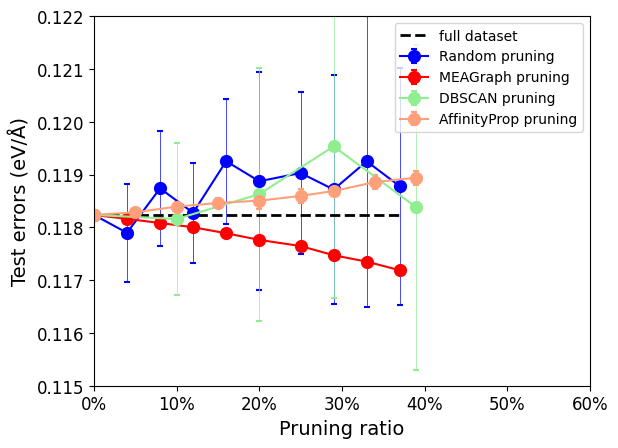

In [89]:

from matplotlib.ticker import FuncFormatter, FormatStrFormatter

def percentage_formatter(x, pos):
    return f'{int(x * 100)}%'
pruning_frac=[round((len(df)-keep_num)/len(df),2) for keep_num in keep_num_ave_list]
pruning_frac_ap=[round((len(df)-keep_num)/len(df),2) for keep_num in ap_keep_num_ave_list][:-1]
pruning_frac_db=[round((len(df)-keep_num)/len(df),2) for keep_num in db_keep_num_ave_list][:-5]
plt.plot(figsize=(8,6))
plt.errorbar(
    pruning_frac,
    np.array(random_mse_test_ave_list),
    yerr=np.array(random_mse_test_std_list),
    label='Random pruning',
    marker='o',
    linestyle='-', 
    color='blue',
    capsize=2,  # Size of error bar caps
    elinewidth=0.5,  # Width of error bar lines
    markeredgewidth=1.5,  # Width of marker edge
    markersize=8,  # Size of markers
)
plt.errorbar(
    pruning_frac,
    np.array(mse_test_ave_list),
    yerr=np.array(mse_test_std_list),
    label='MEAGraph pruning',
    marker='o',
    linestyle='-', 
    color='red',
    capsize=2,  
    elinewidth=0.5,  
    markeredgewidth=1.5, 
    markersize=8,  
)

plt.errorbar(
    pruning_frac_db,
    np.array(db_mse_test_ave_list)[:-5],
    yerr=np.array(db_mse_test_std_list)[:-5],
    label='DBSCAN pruning',
    marker='o',
    linestyle='-', 
    color='lightgreen',
    capsize=2,  
    elinewidth=0.5,  
    markeredgewidth=1.5, 
    markersize=8, 
)

plt.errorbar(
    pruning_frac_ap,
    np.array(ap_mse_test_ave_list)[:-1],
    yerr=np.array(ap_mse_test_std_list)[:-1],
   # label='AP pruning',
    label='AffinityProp pruning',
    marker='o',
    linestyle='-', 
    color='lightsalmon',
    capsize=2, 
    elinewidth=0.5, 
    markeredgewidth=1.5, 
    markersize=8,  
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
# Set the y-axis formatter to display three digits
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(pruning_frac,[mse_test_ave_list[0]]*len(pruning_frac),color='black',linestyle='--',linewidth=2,label='full dataset')


plt.legend()
#plt.ylim(5.5,8.5)
plt.ylim(0.115,0.122)
plt.xlim(0,0.6)
plt.xlabel('Pruning ratio',fontsize=14)
plt.ylabel('Test errors (eV/Å)',fontsize=14)
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('pruning_Ta.pdf',dpi=600,bbox_inches='tight')
plt.savefig('pruning_Ta_alldirection_transparent.pdf',dpi=600,bbox_inches='tight',transparent=True)

- Distribution of atoms for the initial training dataset and its final pruned dataset

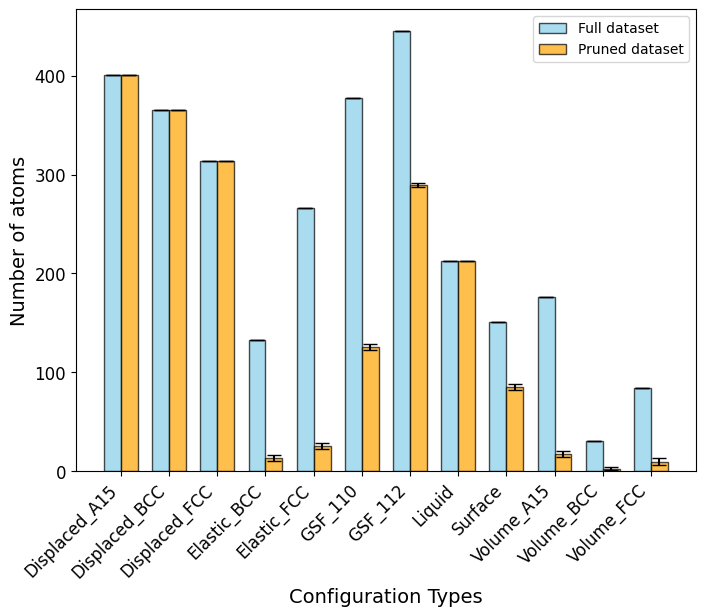

In [12]:
from collections import Counter, defaultdict

def update_stats(group_name_list):
    stats_groups=defaultdict(list)
    for group_names in group_name_list:
        count_dict = Counter(group_names)
        for name, count in count_dict.items():
            stats_groups[name].append(count)
    return stats_groups

stats_init_groups = update_stats(group_name_init_list)
stats_fin_groups = update_stats(group_name_fin_list)

import pandas as pd
import matplotlib.pyplot as plt

df_stats_init_groups = pd.DataFrame.from_dict(stats_init_groups, orient='index').transpose()
df_stats_fin_groups = pd.DataFrame.from_dict(stats_fin_groups, orient='index').transpose()


column_order = ['Displaced_A15', 'Displaced_BCC', 'Displaced_FCC', 'Elastic_BCC', 'Elastic_FCC', 'GSF_110', 'GSF_112', 'Liquid', 'Surface', 'Volume_A15', 'Volume_BCC', 'Volume_FCC']
df_stats_init_groups=df_stats_init_groups.reindex(columns=column_order)
df_stats_fin_groups=df_stats_fin_groups.reindex(columns=column_order)
df_stats_init_groups.fillna(0, inplace=True)
df_stats_fin_groups.fillna(0, inplace=True)
# Combine the DataFrames
df_combined = pd.concat([df_stats_init_groups, df_stats_fin_groups], axis=1, keys=['Initial', 'Final'])


means = df_combined.mean()
stds = df_combined.std()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the width of each bar and the spacing between groups
bar_width = 0.35
opacity = 0.7

# Create the x-tick positions
x = np.arange(len(df_combined.columns.levels[1]))

# Plot the means as bars for the initial groups
ax.bar(x - bar_width/2, means['Initial'], bar_width, yerr=stds['Initial'], capsize=5, alpha=opacity, color='skyblue', edgecolor='black', label='Full dataset')

# Plot the means as bars for the final groups
ax.bar(x + bar_width/2, means['Final'], bar_width, yerr=stds['Final'], capsize=5, alpha=opacity, color='orange', edgecolor='black', label='Pruned dataset')


ax.set_xticks(x)
ax.set_xticklabels(df_combined.columns.levels[1],fontsize=12)


ax.set_xlabel('Configuration Types',fontsize=14)
ax.set_ylabel('Number of atoms',fontsize=14)


ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', labelsize=12)
# Display the plot
# plt.tight_layout()
plt.savefig('group_stats_Ta_Alldirections.pdf',dpi=600,bbox_inches='tight')

In [91]:
import random
random.seed(42)
# Count the number of atoms belonging to each unique value of 'Groups'
group_counts = {}
for count in range(len(testdata)):
    group = testdata[count].labels[0]['Groups']
    group_counts[group] = group_counts.get(group, 0) + 1

# Determine the minimum count among these
min_count = min(group_counts.values())

# Sample an equal number of atoms for each unique value of 'Groups' based on the minimum count
sampled_data = []
X_test_groups,y_test_groups,label_test_groups=[],[],[]
for group, count in group_counts.items():
    group_samples = [testdata[i] for i in range(len(testdata)) if testdata[i].labels[0]['Groups'] == group]
    
    sampled_data=random.sample(group_samples, min_count)
    sampled_data_groups_x=np.squeeze(np.array([data.x.numpy() for data in sampled_data]))
    xtest_groups = np.vstack((sampled_data_groups_x[:, :num_feats],
                        sampled_data_groups_x[:, num_feats:num_feats*2],
                        sampled_data_groups_x[:, num_feats*2:num_feats*3]))
    xtest_groups=np.squeeze(xtest_groups)
    X_test_groups.append(xtest_groups)
    
    # sampled_data_groups_y=np.squeeze(np.array([data.forcex_truths.numpy() for data in sampled_data]))
    ytest_groups = np.vstack((np.array([data.forcex_truths.numpy() for data in sampled_data]),
                        np.array([data.forcey_truths.numpy() for data in sampled_data]),
                        np.array([data.forcez_truths.numpy() for data in sampled_data])))
    ytest_groups=np.squeeze(ytest_groups)

    y_test_groups.append(ytest_groups)
    label_test_groups.append([data.labels[0]['Groups'] for data in sampled_data])

# filtered dataframe with cluster_size larger than 100
from collections import defaultdict
idx_type = 'cluster_idx'

filtered_size_df = df[df['cluster_size'] > size_limit]
grouped_filtered=filtered_size_df.groupby(idx_type)
def sampling(frac,grouped_filtered,df):
    # Randomly removing a certain fraction of each group
    remove_indices= []
    for _, group_data in grouped_filtered:
        # Concatenating the all removed data
        remove_indices.extend(group_data.sample(frac=frac).index)  # Adjust the random_state if needed
    #return the kept data
    keep_data_df = df[~df.index.isin(remove_indices)]   
    return keep_data_df


mse_test_ave_groups,mse_test_std_groups=[],[]


# Specify the pruning fraction to remove a fraction of atoms from the filtered_size_df
#frac_list=[0.1 * i for i in range(0, 10)]
frac_list=[0.0,0.9]
for frac in frac_list:
    mse_test_list,mse_train_list,keep_num_list=[],[],[]
    mse_test_groups=defaultdict(list)
    for i in range(20):
        filtered_df=sampling(frac,grouped_filtered,df)
        filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()
        X_train = np.vstack([filtered_df_feats[:, :num_feats],
                                filtered_df_feats[:, num_feats:num_feats*2],
                                filtered_df_feats[:, num_feats*2:num_feats*3]])
        y_train = pd.concat([filtered_df['forcex_truths'],
                            filtered_df['forcey_truths'],
                            filtered_df['forcez_truths']], axis=0)

        ridge_model.fit(X_train, y_train)
        for x_test_group,y_test_group,label_test_group in zip(X_test_groups,y_test_groups,label_test_groups):
            
            y_pred_test = ridge_model.predict(x_test_group)
            mse_test = mean_squared_error(y_test_group, y_pred_test,squared=False)
            mse_test_groups[label_test_group[0]].append(mse_test)
    mse_test_ave_groups.append({key: np.mean(np.array(values)) for key, values in mse_test_groups.items()})
    mse_test_std_groups.append({key: np.std(np.array(values)) for key, values in mse_test_groups.items()})


In [93]:
#random pruning

# ridge_model = Ridge(alpha=alpha)
# random.seed(0)
random_mse_test_ave_groups,random_mse_test_std_groups=[],[]
for count,keep_num in enumerate(keep_num_ave_list):
    if count != len(keep_num_ave_list)-1: continue
    random_mse_test_list,random_mse_train_list=[],[]
    for i in range(20):
        filtered_df=df.sample(n=int(keep_num))
    
        filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()

        X_train = np.vstack([filtered_df_feats[:, :num_feats],
                     filtered_df_feats[:, num_feats:num_feats*2],
                     filtered_df_feats[:, num_feats*2:num_feats*3]])
        y_train = pd.concat([filtered_df['forcex_truths'],
                     filtered_df['forcey_truths'],
                     filtered_df['forcez_truths']], axis=0)

        ridge_model.fit(X_train, y_train)
        for x_test_group,y_test_group,label_test_group in zip(X_test_groups,y_test_groups,label_test_groups):
            y_pred_test = ridge_model.predict(x_test_group)
            mse_test = mean_squared_error(y_test_group, y_pred_test,squared=False)
            mse_test_groups[label_test_group[0]].append(mse_test)
    random_mse_test_ave_groups.append({key: np.mean(np.array(values)) for key, values in mse_test_groups.items()})
    random_mse_test_std_groups.append({key: np.std(np.array(values)) for key, values in mse_test_groups.items()})


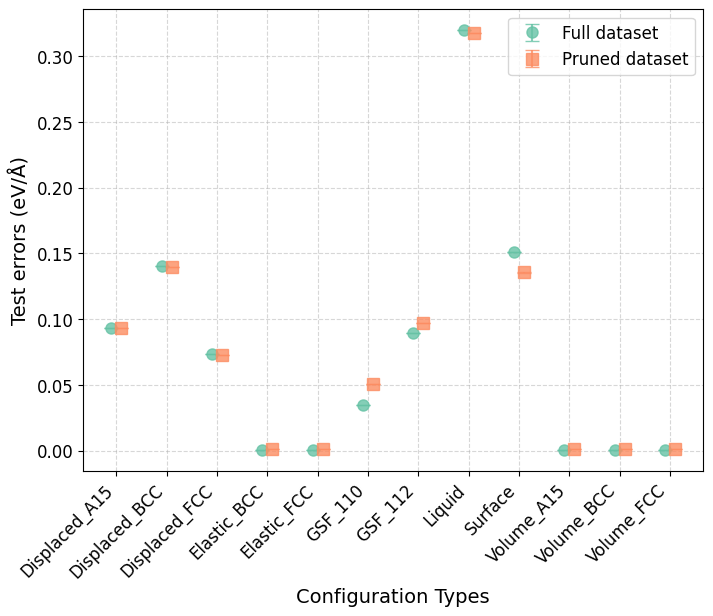

In [100]:
import matplotlib.pyplot as plt
import numpy as np

keys = ['Displaced_A15', 'Displaced_BCC', 'Displaced_FCC', 'Elastic_BCC', 'Elastic_FCC', 'GSF_110', 'GSF_112', 'Liquid', 'Surface', 'Volume_A15', 'Volume_BCC', 'Volume_FCC']

mse_test_ave_groups_init= {key: mse_test_ave_groups[0].get(key) for key in keys}
mse_test_ave_groups_fin= {key: mse_test_ave_groups[1].get(key) for key in keys}
mse_test_std_groups_init= {key: mse_test_std_groups[0].get(key) for key in keys}
mse_test_std_groups_fin= {key: mse_test_std_groups[1].get(key) for key in keys}

# keys = list(mse_test_ave_groups[0].keys())
mse_ave_init = np.array(list(mse_test_ave_groups_init.values()))
mse_ave_fin = np.array(list(mse_test_ave_groups_fin.values()))
mse_std_init = np.array(list(mse_test_std_groups_init.values()))
mse_std_fin = np.array(list(mse_test_std_groups_fin.values()))

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(keys))

# Create a color palette
palette = plt.get_cmap('Set2')

# Plot the first set of data points with error bars
ax.errorbar(x, mse_ave_init, yerr=mse_std_init, marker='o', markersize=8, linestyle='none', capsize=5,
            color=palette(0), label='Full dataset', alpha=0.8)

# Plot the second set of data points with error bars
ax.errorbar(x + 0.2, mse_ave_fin, yerr=mse_std_fin, marker='s', markersize=8, linestyle='none', capsize=5,
            color=palette(1), label='Pruned dataset', alpha=0.8)

ax.set_xlabel('Configuration Types', fontsize=14)
ax.set_ylabel('Test errors (eV/Å)', fontsize=14)
ax.set_xticks(x + 0.1)
#ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
# Add grid lines
ax.grid(linestyle='--', alpha=0.5)

# Adjust spacing between subplots
# plt.tight_layout()
# Save the figure
plt.savefig(f'mse_groups_Ta_all_rate{rate}_sizelimit{size_limit}.pdf', dpi=600, bbox_inches='tight', transparent=True)

- TSNE plot of atomic features of all atoms in the training dataset

In [7]:
import torch
import pandas as pd
import umap
import numpy as np
from sklearn.manifold import TSNE
# umap_model = umap.UMAP(n_components=2, random_state=42)
data=torch.load(f"{results_dir}/graph_{group_name_strs}_train{train_val_ratio}_data.pt")
x=data.x

In [8]:
# Apply TSNE transformation for feature matrix
# df_ForcePreds=pd.DataFrame(forcex_preds)
# df_ForceTruths=pd.DataFrame(forcex_truths)
df_feats=pd.DataFrame(x)

tsne = TSNE(n_components=3,random_state=42)
numeric_df = df_feats.iloc[:, :num_feats*3]
X_tsne = tsne.fit_transform(numeric_df)
df_tsneFeats=pd.DataFrame(X_tsne)
df_tsneFeats.reset_index(inplace=True)
df_tsneFeats.rename(columns={'index':'Atom_ID'},inplace=True)

In [9]:
def plot_tsne_config_2d(df, point_size=1, vmax_limit=None, vmin_limit=None, elev=30, azim=45):
    cmap = plt.cm.get_cmap('nipy_spectral')
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)


    unique_config_names = df['Groups'].unique()
    print(unique_config_names)
# Define a colormap with 12 distinct colors
    colormap = plt.cm.get_cmap('tab20', len(unique_config_names))

    # Map config_name values to colors
    color_mapping = {config_name: colormap(i) for i, config_name in enumerate(unique_config_names)}

    # Plot scatter plot
    sc=ax.scatter(df['x_0'], df['x_1'],s=point_size,c=df['Groups'].map(color_mapping), label=df['Groups'])

    ax.set_xlabel('Feature 1',fontsize=18)
    ax.set_ylabel('Feature 2',fontsize=18)
    plt.tick_params(axis='both', labelsize=16)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[config_name], label=config_name)
           for config_name in unique_config_names]

    plt.legend(handles=handles, title='Config Types', bbox_to_anchor=(1.05,1),loc='upper right')


    plt.tight_layout()

    # Show the plot
    
    plt.savefig('Ta_features.pdf',dpi=600,bbox_inches='tight')

/var/tmp/sun36/ipykernel_2031638/2068931858.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral')
/var/tmp/sun36/ipykernel_2031638/2068931858.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_config_names))


['GSF_110' 'Volume_FCC' 'Displaced_A15' 'Elastic_FCC' 'Volume_A15'
 'Elastic_BCC' 'GSF_112' 'Surface' 'Displaced_BCC' 'Displaced_FCC'
 'Liquid' 'Volume_BCC']


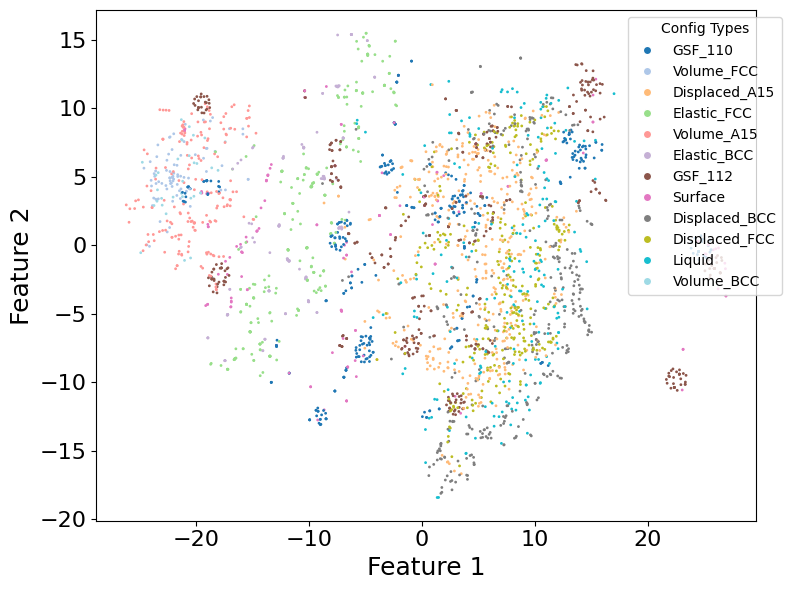

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import json
# import umap
import pickle

train_val_ratio=0.8
new_columns={0:'cluster_idx',1:'cluster_size'}

with open(jsonfile_path,'r') as json_file:
     node_info=json.load(json_file)
df_info = pd.DataFrame.from_dict(node_info,orient='index')
df_info.rename(columns=new_columns,inplace=True)
df_info.reset_index(inplace=True)  
df_info.rename(columns={'index':'Atom_ID'},inplace=True)
df_info['Atom_ID'] = df_info['Atom_ID'].astype(int)  

df_tsneFeats_info = pd.merge(df_tsneFeats, df_info, on='Atom_ID')
df_tsneFeats_info.rename(columns={0:'x_0',1:'x_1',2:'x_2'},inplace=True)

df_tsneFeats_info = pd.merge(df_tsneFeats_info, df_labels, on='Atom_ID')



# plot_tsne_config_3d(df_tsneFeats_info)
plot_tsne_config_2d(df_tsneFeats_info)
# plot_tsne_3d(df)
